<h2>Import bibliotek</h2>

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

<h2>Zadanie 1.</h2>

Wczytanie zbioru danych populacji

In [2]:
# Read population data
population_data = pd.io.parsers.read_csv("things/population.dat", header = None, names = ['year', 'population'])

population_data

,year,population
0,1900,76212168
1,1910,92228496
2,1920,106021537
3,1930,123202624
4,1940,132164569
5,1950,151325798
6,1960,179323175
7,1970,203302031
8,1980,226542199
9,1990,248709873


Funkcje do aproksymacji średniokwadratowej

In [3]:
# function that returns coefficients got from least squares approximation
def least_squares_approximation(degree, points):
    A = points[:,0][:,np.newaxis] ** np.arange(0, degree+1)
    y = points[:,1]
    return np.linalg.solve(A.T @ A, A.T @ y)

# function that uses horner method to evaluate a polynomial
def evaluate_horner(coefficients, x):
    result = 0
    for c in reversed(coefficients):
        result = x * result + c
    return result

<h3>a) Użycie aproksymacji średniokwadratowej do ekstrapolacji wielomianu</h3>

Zdefiniowanie stopni wielomianów

In [4]:
# define degrees for least squares approximations
degrees = np.arange(0, 7)

Definicja zbioru punktów i prawdziwej wartości dla roku 1990

In [15]:
# define points used for least squares approximation
points = np.float64(population_data[population_data['year'] <= 1980].values)
# define the population for year 1990
actual_1990 = population_data[population_data['year'] == 1990]['population'].values[0]

Obliczenie współczynników wielomianów

In [6]:
# calculate coefficients of polynomials for given degrees and points
coefficients = [least_squares_approximation(degree, points) for degree in degrees]

Narysowanie wykresu otrzymanych wielomianów

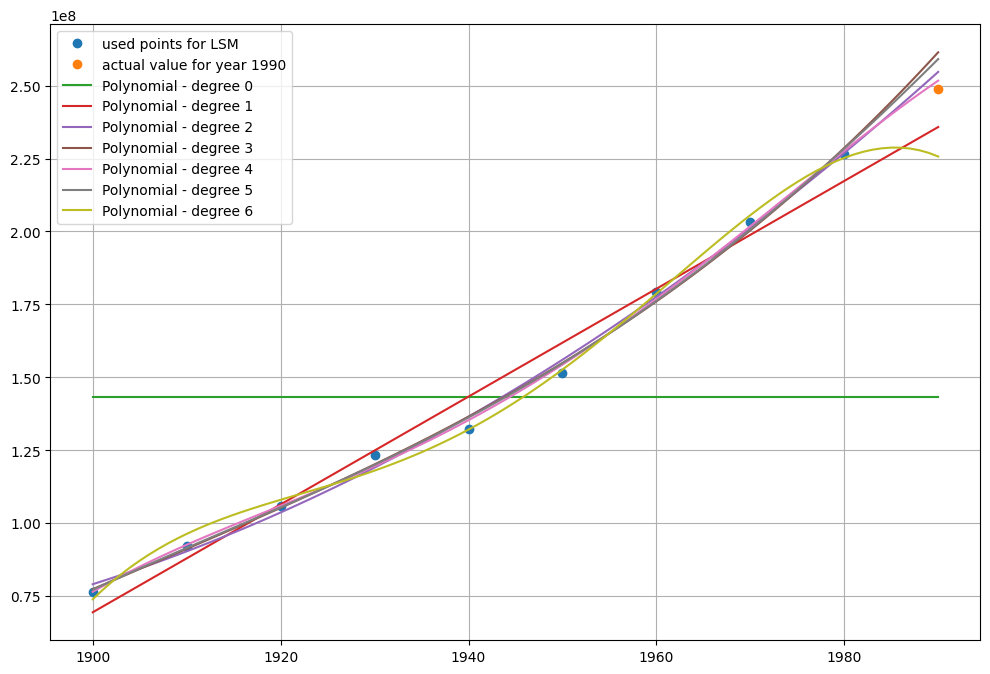

In [7]:
# set figsize
plt.figure(figsize = (12,8))
# plot used points for LSM
plt.plot(points[:,0], points[:,1], label="used points for LSM", linestyle='', marker='o')
# plot actual value for the year 1990
plt.plot(1990, actual_1990, label="actual value for year 1990", linestyle='', marker='o')
# plot calculated polynomials
xs = np.arange(1900, 1991, 1)
for i, coeffs in enumerate(coefficients):
    ys = [evaluate_horner(coeffs, x) for x in xs]
    plt.plot(xs, ys, label=f"Polynomial - degree {i}")
# show plot with grid and legend
plt.grid()
plt.legend()
plt.show()

Porównanie błędu względnego dla roku 1990 w zależności od stopnia wielomianu

In [8]:
# calculate estimated values for year 1990
estimated_1990 = np.array([evaluate_horner(coeffs, 1990) for coeffs in coefficients])
# calculate the relative error for estimations
relative_errors = np.round(abs(estimated_1990 - actual_1990) / actual_1990, 4)
# print the correct population
print(f"Correct population for year 1990: {"{:,}".format(actual_1990).replace(","," ")}")
# print dataframe of estimated population and relative errors by degree
print("Estimated population for year 1990 (rounded to nearest integer) by polynomial degree:")
pd.DataFrame(data={
    'Estimated population': ["{:,}".format(round(est)).replace(",", " ") for est in estimated_1990],
    'Relative error': relative_errors
})

Correct population for year 1990: 248 709 873
Estimated population for year 1990 (rounded to nearest integer) by polynomial degree:


,Estimated population,Relative error
0,143 369 177,0.4235
1,235 808 109,0.0519
2,254 712 945,0.0241
3,261 439 111,0.0512
4,251 719 359,0.0121
5,259 115 342,0.0418
6,225 702 990,0.0925


<h3>b) Kryterium informacyjne Akaikego</h3>

<span style="font-size: 16pt">$AIC = 2k + n\ln(\frac{\sum_{i=1}^{n}[y_i - \hat{y}(x_i)]^2}{n})$</span>
</br>
<span style="font-size: 16pt">$AIC_c = AIC + \frac{2k(k+1)}{n-k-1}$</span>
</br>
<span style="font-size: 12pt">$k = m+1$, gdzie $m$ to stopień wielomianu</span>
</br>
<span style="font-size: 12pt">$n$ to rozmiar próbki</span>
</br>
<span style="font-size: 12pt">$y_i - \hat{y}(x_i)$ to różnica wartości prawdziwej i przewidywanej</span>

In [9]:
# calculate AIC
def aic(degree, correct, predicted):
    k = degree + 1
    n = len(correct)
    return 2*k + n*np.log(np.sum((correct - predicted) ** 2) / n)

# calculate AIC_c
def aic_c(degree, correct, predicted):
    k = degree + 1
    n = len(correct)
    return aic(degree, correct, predicted) + 2*k*(k+1) / (n-k-1)

Wyznaczenie kreterium informacyjnego Akaikego dla danych wielomianów

In [10]:
# calculate the predicted values
predicted_values = [evaluate_horner(coeffs, np.arange(1900, 1981, 10)) for coeffs in coefficients]

# calculate aic_c for all polynomials
aic_c = [aic_c(i, points[:,1], predicted) for i, predicted in enumerate(predicted_values)]

Wypisanie wyznaczonych kreteriów

In [13]:
print("AIC_c by polynomial degree:")
pd.DataFrame(data={
    r"$AIC_c$": np.round(aic_c,3)
})

AIC_c by polynomial degree:


,$AIC_c$
0,321.011
1,289.056
2,279.453
3,284.880
4,292.672
5,319.828
6,392.074


Narysowanie najdokładniej ekstrapolującego wielomianu wg. $AIC_c$ (tj. stopnia 2.) i w praktyce (tj. stopnia 4.)

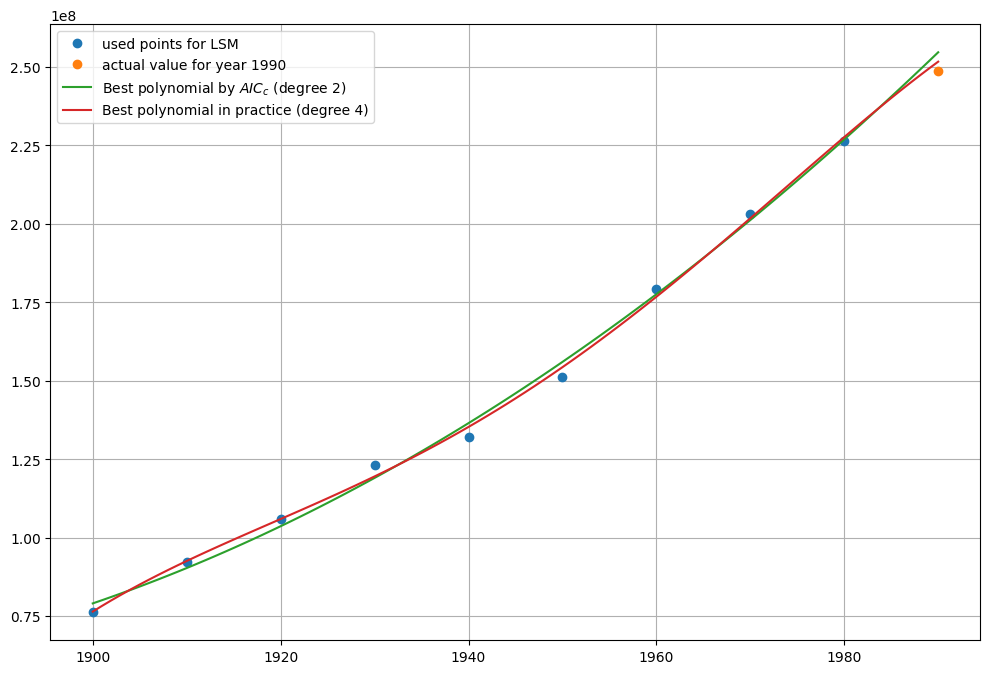

In [20]:
# set figsize
plt.figure(figsize = (12,8))
# plot used points for LSM
plt.plot(points[:,0], points[:,1], label="used points for LSM", linestyle='', marker='o')
# plot actual value for the year 1990
plt.plot(1990, actual_1990, label="actual value for year 1990", linestyle='', marker='o')
# plot polynomial of m = 2 and m = 4
xs = np.arange(1900, 1991, 1)
ys_2 = [evaluate_horner(coefficients[2], x) for x in xs]
ys_4 = [evaluate_horner(coefficients[4], x) for x in xs]
plt.plot(xs, ys_2, label="Best polynomial by $AIC_c$ (degree 2)")
plt.plot(xs, ys_4, label="Best polynomial in practice (degree 4)")
# show plot with grid and legend
plt.grid()
plt.legend()
plt.show()